In [3]:
!uv pip install langgraph langsmith
!uv pip install dashscope

Now using Node v24.8.0 (npm 11.6.0) ~/.local/share/nvm/v24.8.0/bin/node
Audited 2 packages in 5ms
Now using Node v24.8.0 (npm 11.6.0) ~/.local/share/nvm/v24.8.0/bin/node
Resolved 19 packages in 3.05s                                        
⠹ Preparing packages... (0/2)                                                   
⠸ Preparing packages... (0/2)--------------     0 B/1.25 MiB            
⠸ Preparing packages... (0/2)--------------     0 B/1.25 MiB            
⠸ Preparing packages... (0/2)-------------- 16.00 KiB/1.25 MiB          
⠸ Preparing packages... (0/2)-------------- 32.00 KiB/1.25 MiB          
⠸ Preparing packages... (0/2)-------------- 48.00 KiB/1.25 MiB          
⠼ Preparing packages... (0/2)-------------- 61.49 KiB/1.25 MiB          
⠼ Preparing packages... (0/2)-------------- 61.49 KiB/1.25 MiB          
⠼ Preparing packages... (0/2)-------------- 77.49 KiB/1.25 MiB          
⠼ Preparing packages... (0/2)-------------- 93.49 KiB/1.25 MiB          
⠼ Preparing packages..

In [1]:
from langgraph.prebuilt import create_react_agent
from langchain_community.chat_models import ChatTongyi
import os
import dotenv


dotenv.load_dotenv()

llm = ChatTongyi(
    model="qwen-turbo",
    api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0.3,
    streaming=True,
)
agent = create_react_agent(llm, tools=[], prompt="你是一个有用的智能助手")
result=""
for chunk in agent.stream(
    {"message": [{"role": "user", "content": "你好"}]}, stream_mode="messages"
):
    #(AIMessageChunk(content='你好', additional_kwargs={}, response_metadata={}, id='run--fa4ac8fa-6691-43bd-826d-0e3fbd525497'), {'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent',), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'agent:4a42cb10-dec5-f4ff-1aee-5958aae05780', 'checkpoint_ns': 'agent:4a42cb10-dec5-f4ff-1aee-5958aae05780', 'ls_provider': 'tongyi', 'ls_model_type': 'chat', 'ls_model_name': 'qwen-turbo'})
    # print(chunk)
    result+=chunk[0].content


print(result)

你好！我是你的智能助手，有什么我可以帮你的吗？😊


In [18]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

from langchain_community.chat_models import ChatTongyi
from pydantic import BaseModel,Field
from typing import Sequence




In [ ]:
class State(TypedDict):
    # messages 是一个列表类型，并且需要使用 add_messages 方法
    # add_messages 方法把message 增加进列表，
    messages: Annotated[list, add_messages]


graph = StateGraph(State)

In [ ]:
class State(BaseModel):
    messages: Annotated[list, add_messages]=Field(default_factory=list)



In [4]:
llm = ChatTongyi(
    model="qwen-turbo",
    api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0.3,
    streaming=True,
)


def chat_bot(state: State):
    return {"messages": llm.invoke(state["messages"])}

In [5]:
def should_continue(state: State):
    """判断是否应该继续对话"""
    last_message = state["messages"][-1].content.lower().strip()
    if any(word in last_message for word in ["quit", "exit", "bye", "退出", "再见"]):
        return "end"
    return "continue"


graph.add_node("chat_bot", chat_bot)
graph.add_edge(START, "chat_bot")
# graph.add_conditional_edges(
#     "chat_bot",
#     should_continue,
#     {
#         "continue": input,  # 继续对话，回到 START 节点
#         "end": END,  # 结束对话
#     },
# )
graph.add_edge("chat_bot", END)

In [99]:
!uv pip install langgraph-checkpoint-redis

Now using Node v24.8.0 (npm 11.6.0) ~/.local/share/nvm/v24.8.0/bin/node
Audited 1 package in 3ms


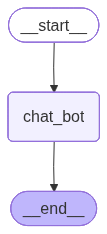

In [ ]:
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.redis import RedisSaver

# memory = MemorySaver()
DB_URI = "redis://localhost:6379"
conn_ctx = RedisSaver.from_conn_string(DB_URI)
memory = conn_ctx.__enter__()
result = graph.compile(checkpointer=memory)
# result = graph.compile()
try:
    # 使用本地渲染
    png_data = result.get_graph().draw_mermaid_png(
        # draw_method=MermaidDrawMethod.PYPPETEER,
        max_retries=5,
        retry_delay=2.0,
    )
    display(Image(png_data))
except Exception as e:
    print(f"本地渲染失败: {e}")
    # 显示文本格式
    print("图结构（文本格式）:")
    print(result.get_graph().draw_mermaid())

In [7]:
from uuid import uuid4

In [16]:
def stream_graph_updates(user_input: str):
    """流式更新图结构"""
    config = {"configurable": {"thread_id": "1"}}
    # 获取当前图结构
    for event in result.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    ):
        print("Assistant: ", event["messages"][-1].pretty_print())
        # print("Assistant: ", value["messages"][-1].content)
    # current_state = result.get_state(config)
    # print("graph: ", current_state.values["messages"])


while True:
    try:
        user_input = input("请输入: ")
        print("user_input: ", user_input)
        if user_input.lower() in ["quit", "exit", "bye", "退出", "再见"]:
            print("再见!")
            break
        stream_graph_updates(user_input)
    except KeyboardInterrupt:
        print("程序已中断")
        break

user_input:  你好
================================ Human Message =================================

你好
Assistant:  None
================================== Ai Message ==================================

你好！很高兴见到你。有什么我可以帮你的吗？
Assistant:  None
user_input:  你是谁？
================================ Human Message =================================

你是谁？
Assistant:  None
================================== Ai Message ==================================

你好！我是通义千问，是阿里巴巴集团旗下的通义实验室自主研发的超大规模语言模型。我被设计用来回答各种问题、创作文字、编程、逻辑推理等任务。你可以问我任何问题，我会尽力提供帮助。有什么我可以帮你的吗？
Assistant:  None
user_input:  你能干什么？
================================ Human Message =================================

你能干什么？
Assistant:  None
================================== Ai Message ==================================

我可以做很多事情，比如：

1. **回答问题**：无论是科学、文化、技术还是日常生活中的问题，我都可以尽力为你解答。
2. **创作文字**：我可以帮你写故事、公文、邮件、剧本、诗歌等。
3. **编程**：我可以帮助你编写和调试代码，支持多种编程语言。
4. **逻辑推理**：我可以进行逻辑分析和推理，解决数学题或逻辑题。
5. **多语言翻译**：我可以将文本翻译成多种语言。
6. **学习辅导**：我可以帮助你学习新知识，提供学习建议和资源。
7. **